# Basic `chromo.eb.` Demo

Below you'll find a quick tutorial on how to use `chromo.eb` to visualize the color dependence of your EB. 

In [1]:
# This lets us change the eb.py file and run the notebook simultaenously,
# without having to reload the notebook every time!
% load_ext autoreload
% autoreload 2

In [2]:
from astropy.modeling import fitting, models
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from chromo import eb

## Download an object.

Below I show how to use `lightkurve` to download a target pixel file containing the EB 'Del Pic'

In [5]:
# Grab an object
tic = 'Del Pic'

In [6]:
sr = lk.search_tesscut(tic)

In [7]:
sr

SearchResult containing 7 data products.

target_name productFilename        description         distance
----------- --------------- -------------------------- --------
    Del Pic             n/a TESS FFI Cutout (sector 1)      0.0
    Del Pic             n/a TESS FFI Cutout (sector 2)      0.0
    Del Pic             n/a TESS FFI Cutout (sector 3)      0.0
    Del Pic             n/a TESS FFI Cutout (sector 4)      0.0
    Del Pic             n/a TESS FFI Cutout (sector 5)      0.0
    Del Pic             n/a TESS FFI Cutout (sector 6)      0.0
    Del Pic             n/a TESS FFI Cutout (sector 7)      0.0

In [8]:
# Download an FFI cut out!
raw_tpf = sr[1].download(cutout_size=[30, 30])

# Cut out any jitter
k = ~((raw_tpf.time > 1346) & (raw_tpf.time < 1350))
raw_tpf = raw_tpf[k]

# No nan frames
raw_tpf = raw_tpf[(raw_tpf.to_lightcurve().flux > 0)]

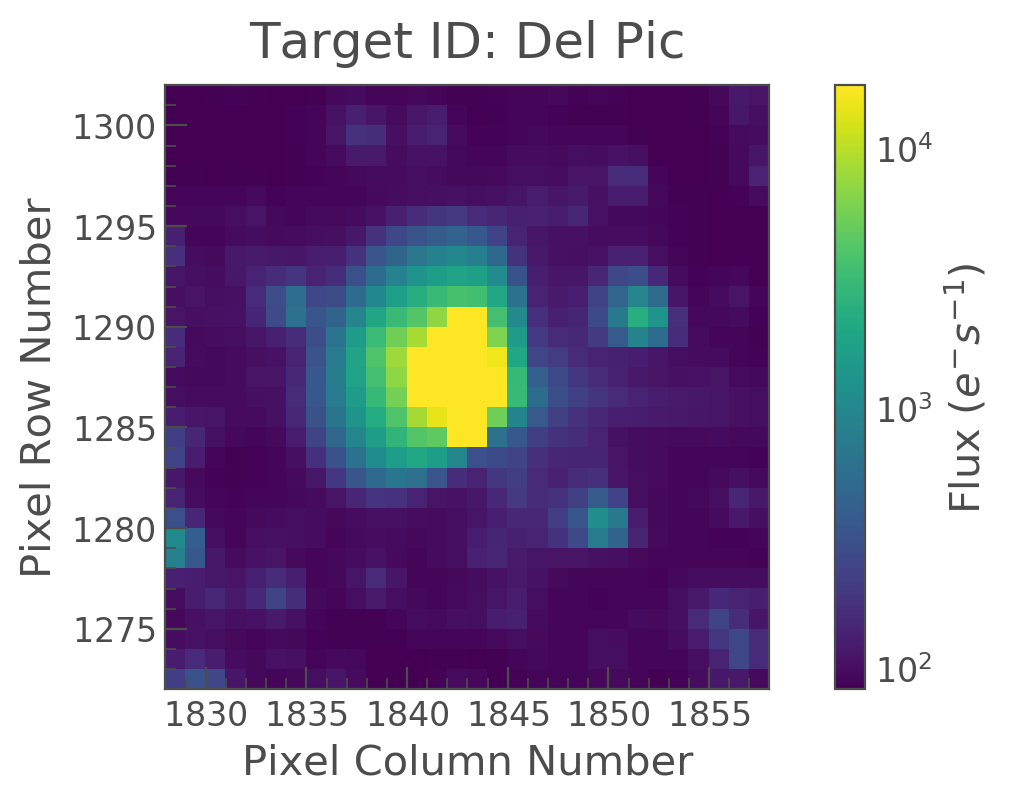

In [9]:
raw_tpf.plot(scale='log')

## Estimate the Period and T0 for EB

We need to find the period and t0 for our EB. You could already have this information to hand, but here is a quick way to do it using light curve.

In [10]:
# Use the chromo background corrector!
# TESS background is really strong, so we need to remove it before we can do anything else.
tpf = eb.background_correct(raw_tpf)

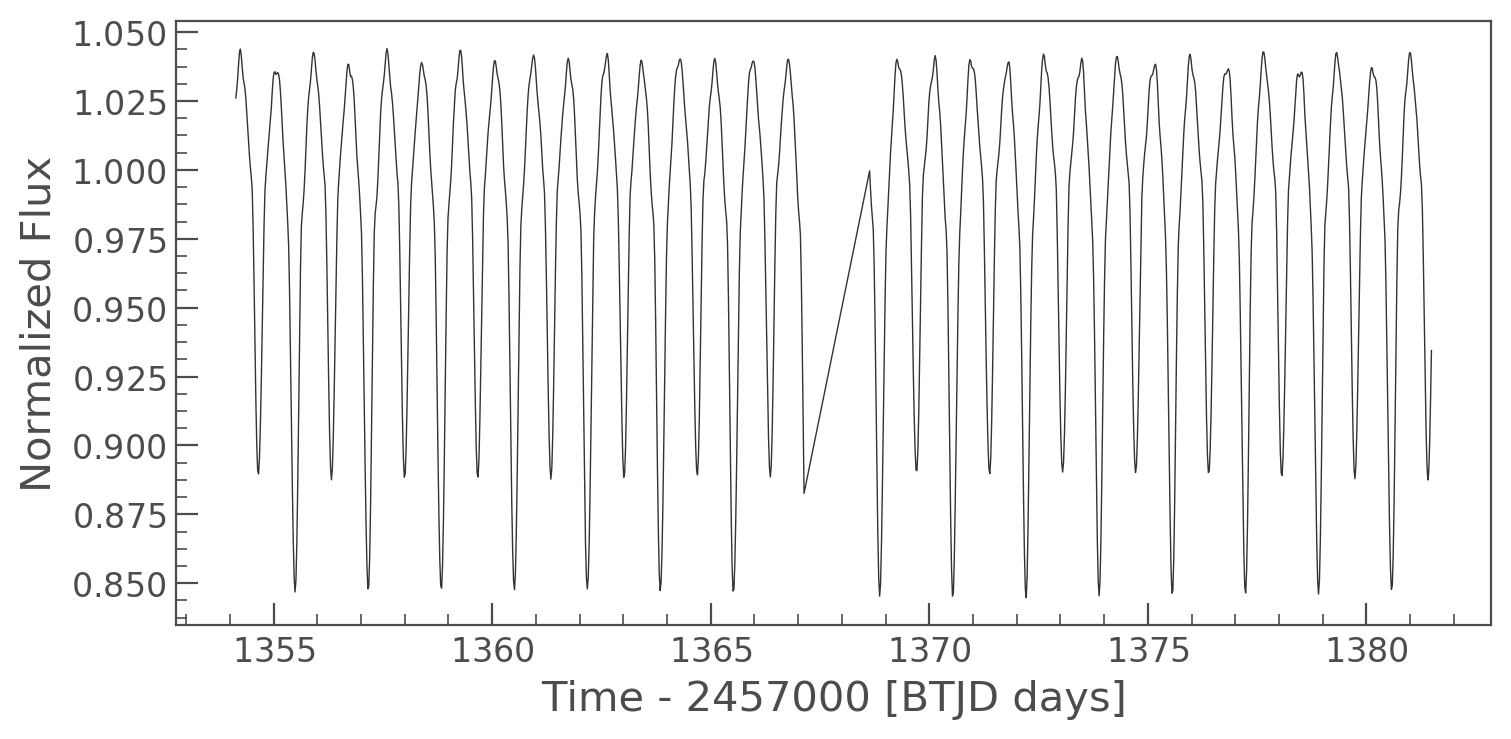

In [11]:
# Take a look!
lc = tpf.to_lightcurve().normalize()
lc.plot()

In [12]:
# Find the period and t0 using a BLS!

# Remember to make sure these values are right for your EB!
duration = 0.08
minimum_period = 1


# Find the first guess of the period
p = lc.to_periodogram('bls', duration=duration, minimum_period=minimum_period, maximum_period=15)
period = p.period_at_max_power.value

# Zoom in and increase the resolution
p = lc.to_periodogram('bls', duration=duration, minimum_period=period * 0.95,
                              maximum_period=period * 1.05, frequency_factor=0.1)

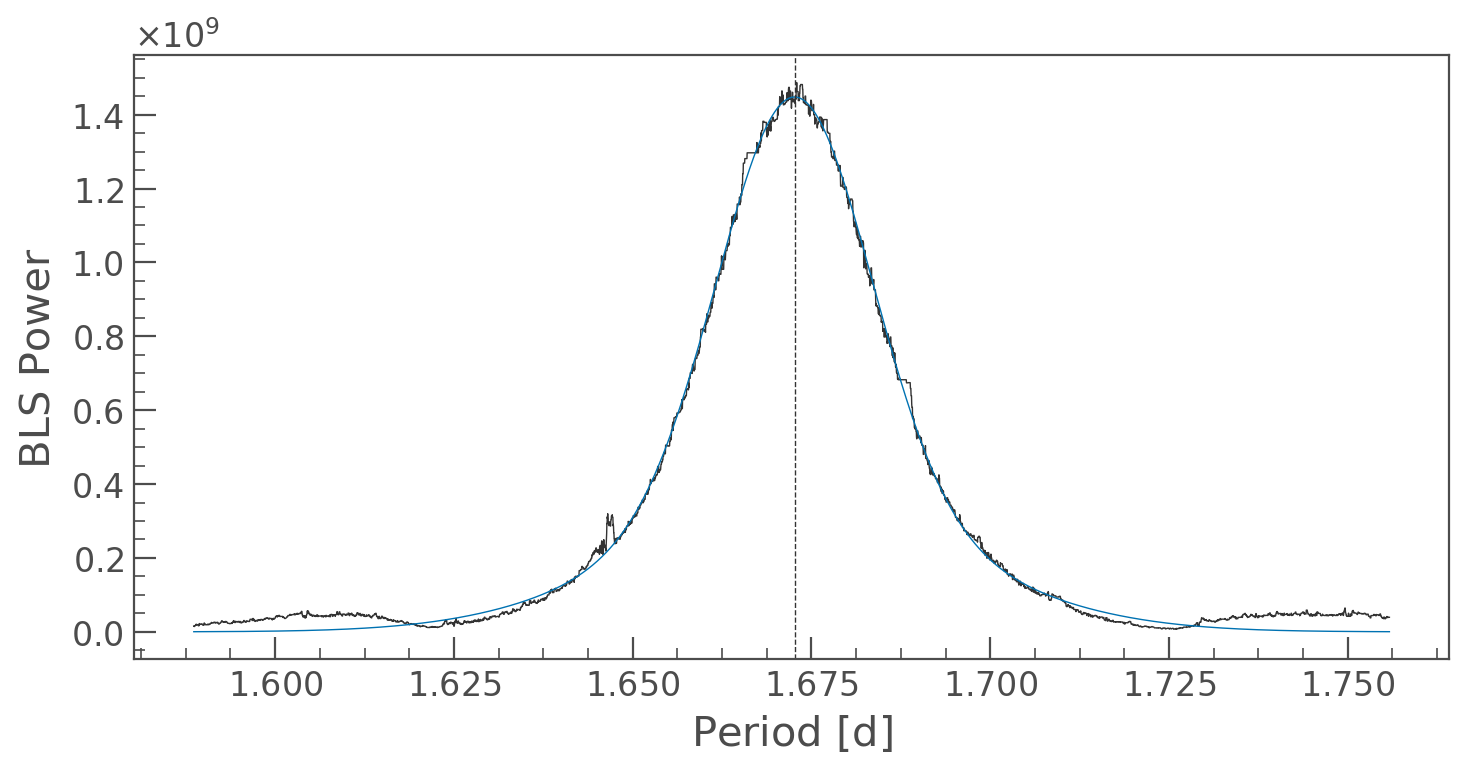

In [13]:
# Plot the periodogram
ax = p.plot()

# Fit a gaussian to the peak.
g_init = models.Gaussian1D(p.power.value.max(), p.period.value.mean(), 0.002) + models.Gaussian1D(p.power.value.max()*0.01, p.period.value.mean(), 0.002)
fit = fitting.LevMarLSQFitter()
g = fit(g_init, p.period.value, p.power.value)
mean = getattr(g, 'mean_{}'.format(np.argmax([g.amplitude_0, g.amplitude_1]))).value

# Plot the fit Gaussian
ax.plot(p.period.value, g(p.period.value))
plt.axvline(mean, ls='--')

# Find the period and T0
pos = np.argmin(np.abs(p.period.value - mean))
period, t0 = p.period[pos].value, p.transit_time[pos]

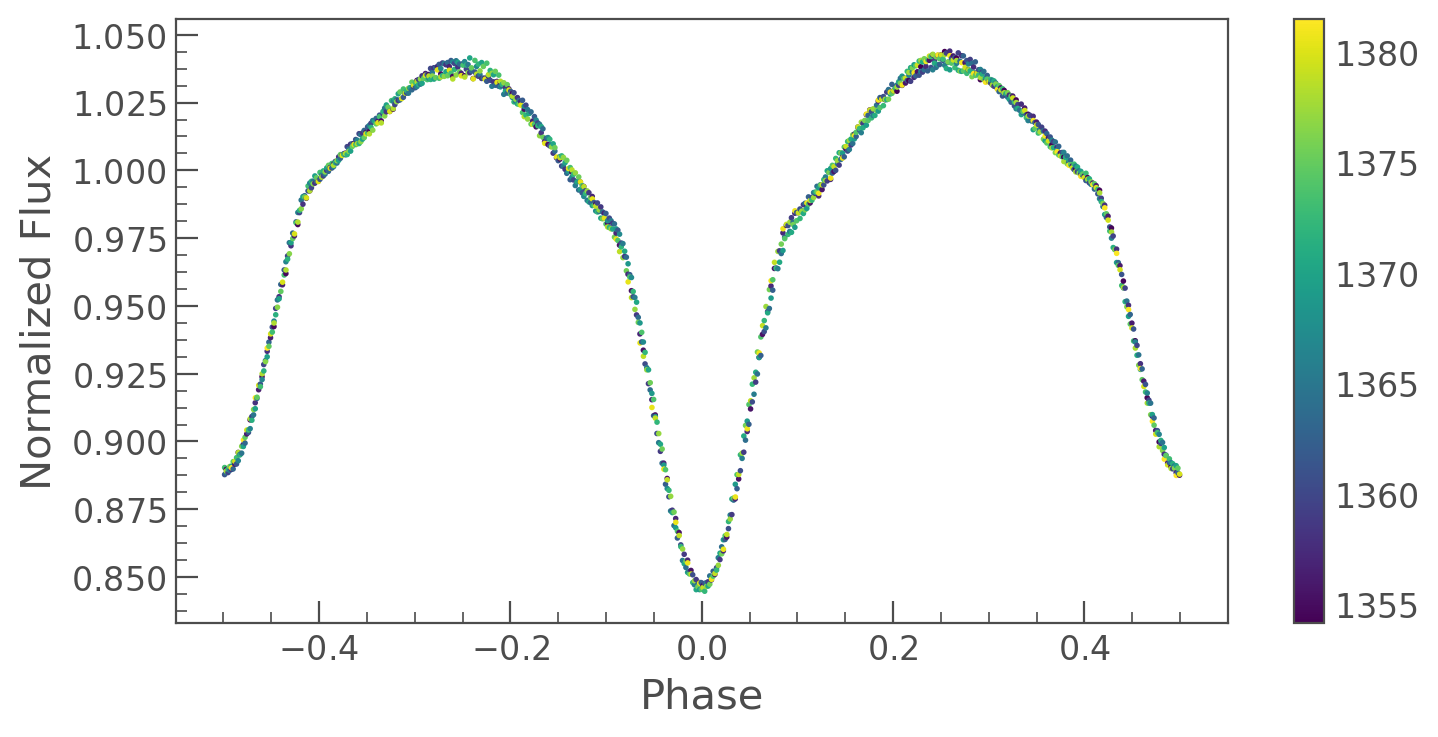

In [14]:
# Check that the light curve folds up nicely at that period
f = lc.fold(period, t0)
f.scatter(c=f.time_original)

## Running `chromo`

Now we have a target pixel file and a period and t0 estimate, we can pass these to chromo, as shown below.

Calculating Pixel Light Curves: 100%|██████████| 30/30 [00:02<00:00, 12.44it/s]


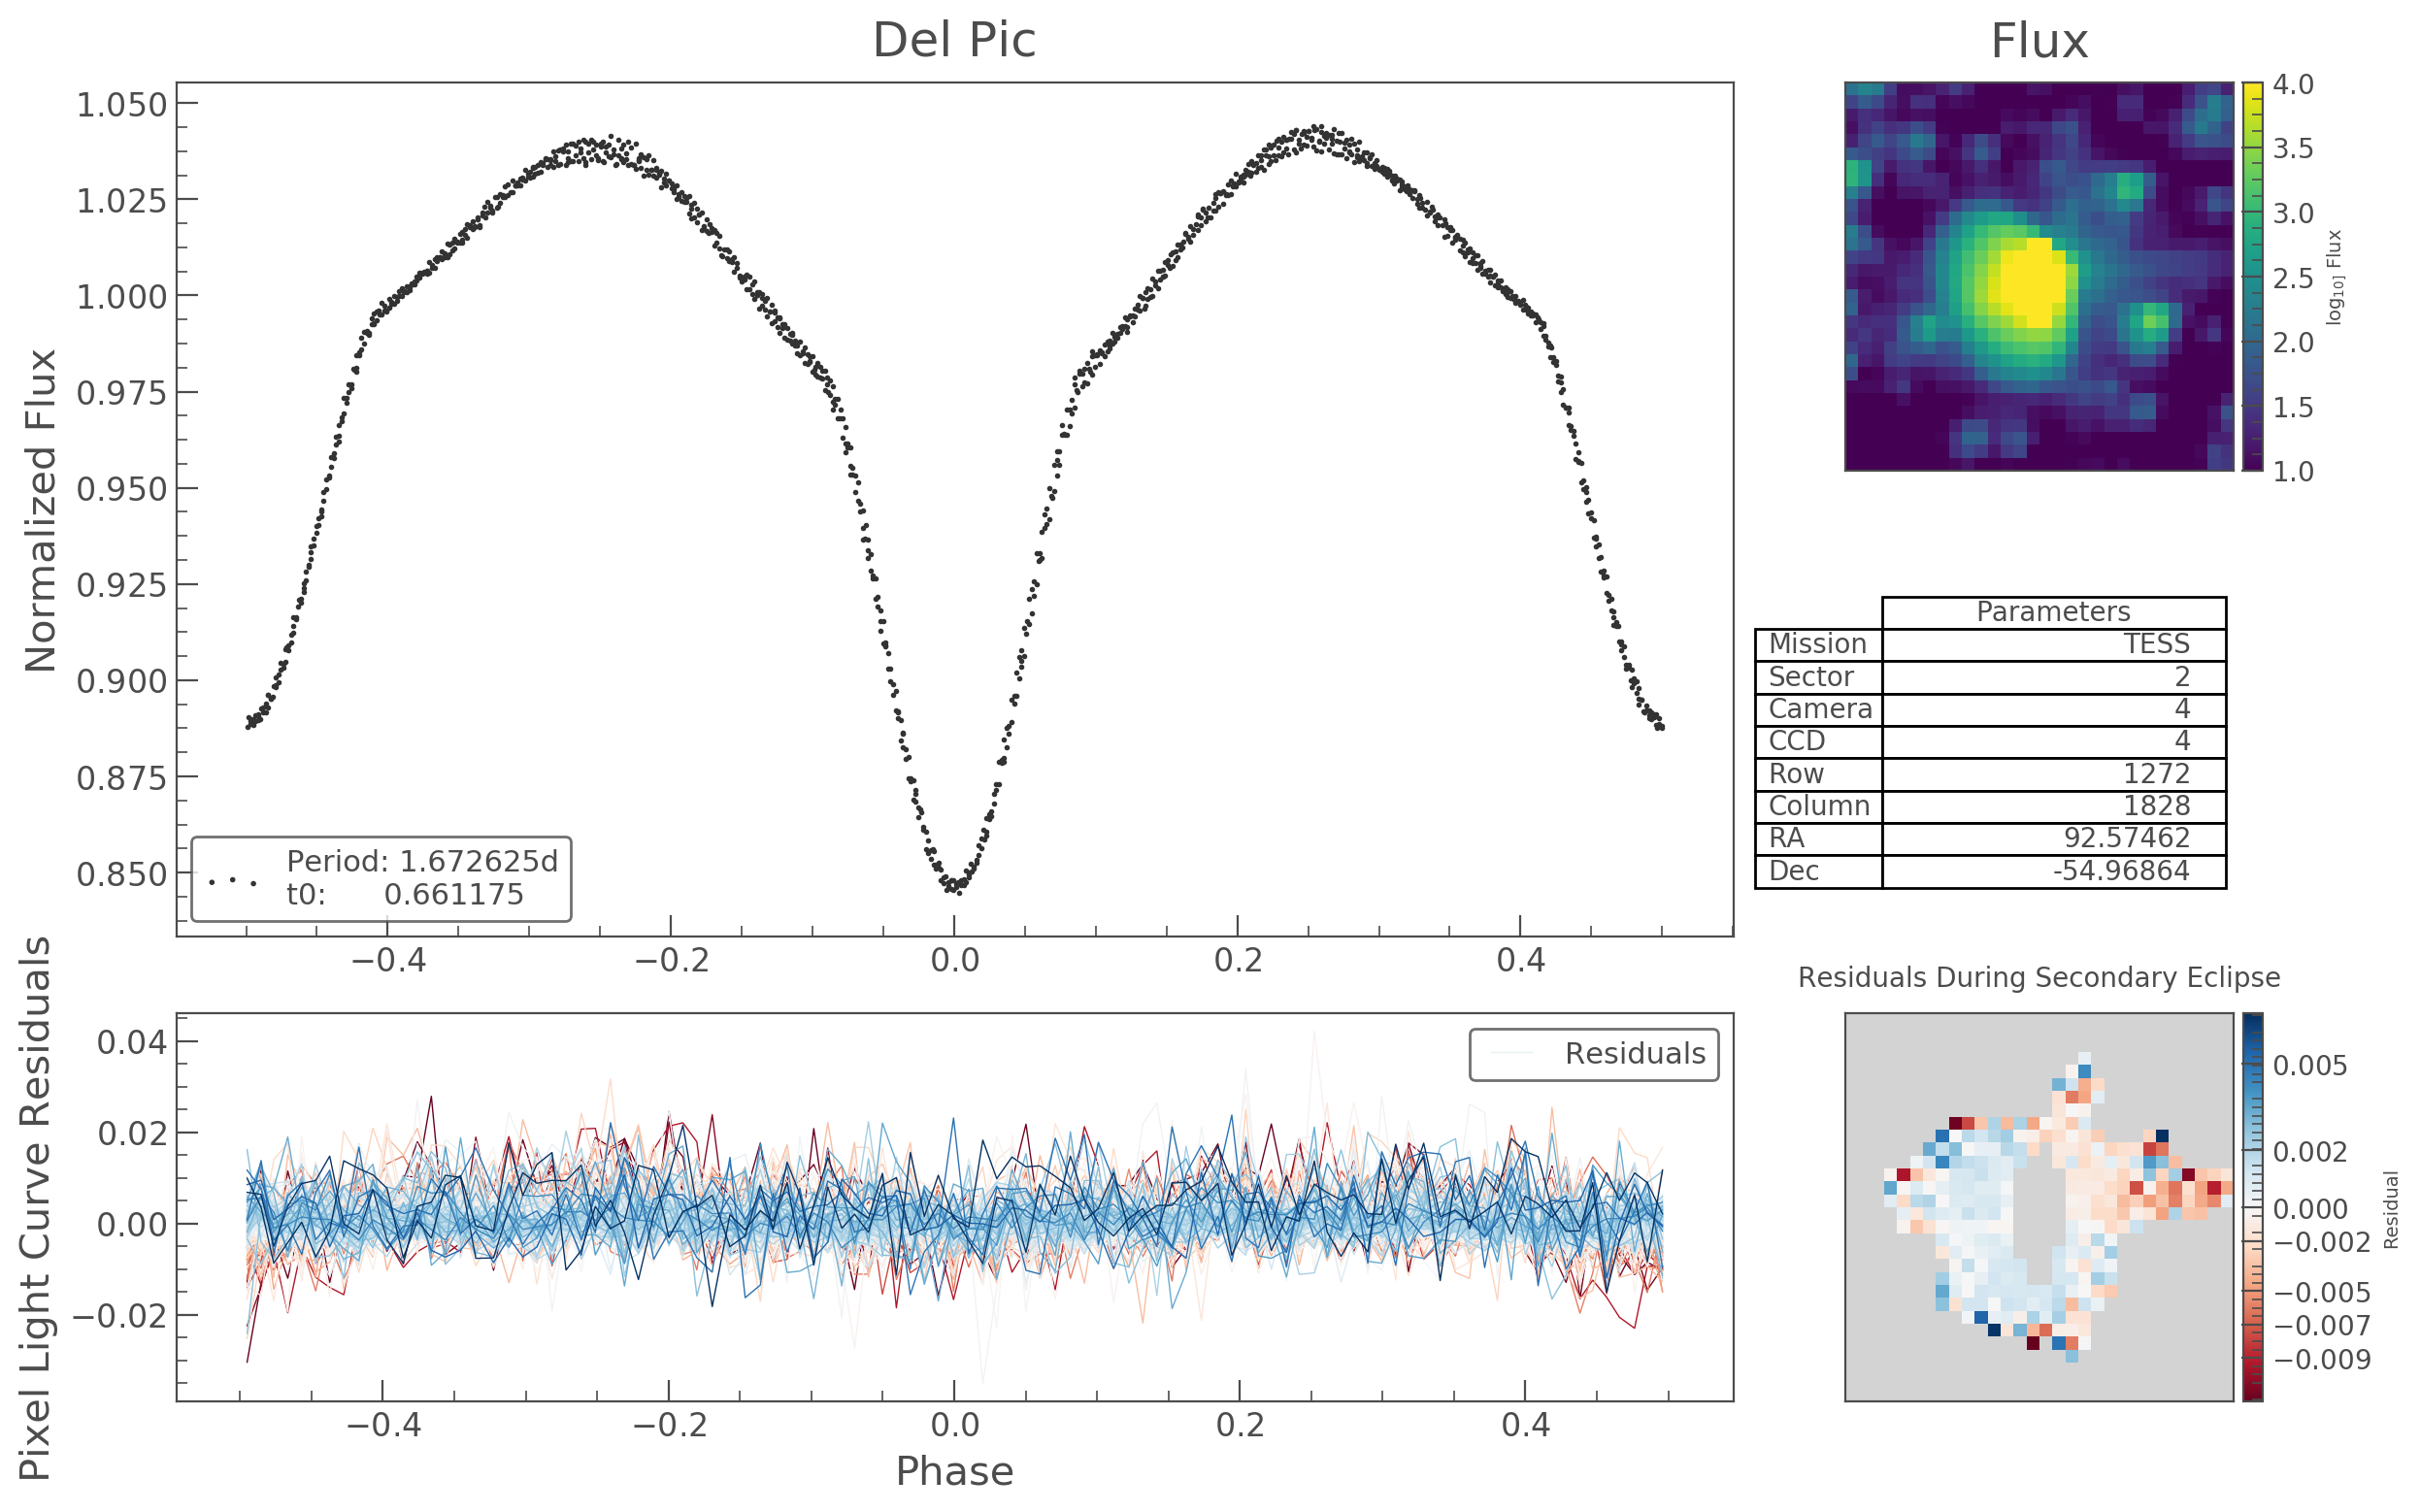

In [15]:
# Use Chromo to analyze! This will make movies in your current directory!
result = eb.analyze(raw_tpf, period, t0, name='{}'.format(tic), nb=100,
                    score_threshold=-300, saturation_aggression=5);